In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import cv2
import numpy as np
from time import time
from scipy.io import savemat
import argparse
import torch
import matplotlib.pyplot as plt
import moviepy.editor as mpe
from tqdm import tqdm_notebook
from collections import defaultdict

from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from decalib.utils.tensor_cropper import transform_points

In [3]:
parser = argparse.ArgumentParser(description='DECA: Detailed Expression Capture and Animation')

parser.add_argument('-i', '--inputpath', default='TestSamples/examples', type=str,
                    help='path to the test data, can be image folder, image path, image list, video')
parser.add_argument('-s', '--savefolder', default='TestSamples/examples/results', type=str,
                    help='path to the output directory, where results(obj, txt files) will be stored.')
parser.add_argument('--device', default='cuda', type=str,
                    help='set device, cpu for using cpu' )
# process test images
parser.add_argument('--iscrop', default=True, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to crop input image, set false only when the test image are well cropped' )
parser.add_argument('--sample_step', default=10, type=int,
                    help='sample images from video data for every step' )
parser.add_argument('--detector', default='fan', type=str,
                    help='detector for cropping face, check decalib/detectors.py for details' )
# rendering option
parser.add_argument('--rasterizer_type', default='standard', type=str,
                    help='rasterizer type: pytorch3d or standard' )
parser.add_argument('--render_orig', default=True, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to render results in original image size, currently only works when rasterizer_type=standard')
# save
parser.add_argument('--useTex', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to use FLAME texture model to generate uv texture map, \
                        set it to True only if you downloaded texture model' )
parser.add_argument('--extractTex', default=True, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to extract texture from input image as the uv texture map, set false if you want albeo map from FLAME mode' )
parser.add_argument('--saveVis', default=True, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save visualization of output' )
parser.add_argument('--saveKpt', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save 2D and 3D keypoints' )
parser.add_argument('--saveDepth', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save depth image' )
parser.add_argument('--saveObj', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save outputs as .obj, detail mesh will end with _detail.obj. \
                        Note that saving objs could be slow' )
parser.add_argument('--saveMat', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save outputs as .mat' )
parser.add_argument('--saveImages', default=False, type=lambda x: x.lower() in ['true', '1'],
                    help='whether to save visualization output as seperate images' );


task_data_dir = 'task_data'
args_str = f'-i {task_data_dir}/selfie -s {task_data_dir}/results --saveDepth True --saveObj True --useTex True --rasterizer_type=pytorch3d'.split(' ')
args = parser.parse_args(args_str)

# Infer your selfie

Поместите в `task_data/selfie` ваше селфи, мб квадратное должно быть. 

В этой папке должно оказаться только одно изображение.

Внутри кода лицо кропается, а на картинке в папке голова помещается полностью.

В след. ячейке визуализируется именно кроп.

creating the FLAME Decoder
trained model found. load /home/user/users/r.bashirov/git/DECA/data/deca_model.tar


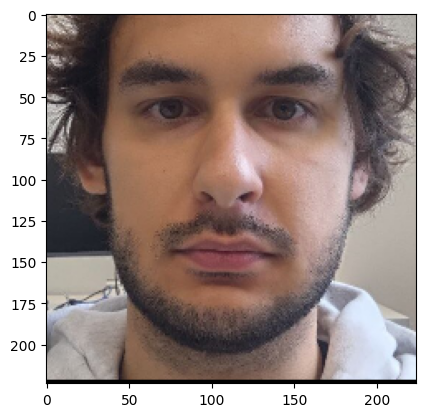

-- please check the results in task_data/results


In [4]:
savefolder = args.savefolder    
device = args.device
os.makedirs(savefolder, exist_ok=True)

# load test images 
testdata = datasets.TestData(args.inputpath, iscrop=args.iscrop, face_detector=args.detector, sample_step=args.sample_step)

# run DECA
deca_cfg.model.use_tex = args.useTex
deca_cfg.model.tex_type = 'FLAME'
deca_cfg.model.flame_tex_path = 'data/FLAME2020/FLAME_texture.npz'
deca_cfg.rasterizer_type = args.rasterizer_type
deca_cfg.model.extract_tex = args.extractTex
deca = DECA(config = deca_cfg, device=device)

assert len(testdata) == 1, 'only 1 image should be in dir TestSamples/examples'

i = 0
name = testdata[i]['imagename']
images = testdata[i]['image'].to(device)[None,...]
img = testdata[i]['image'].detach().cpu().numpy()
plt.imshow((img.transpose(1, 2, 0) * 255).astype(np.uint8))
plt.show()
with torch.no_grad():
    codedict = deca.encode(images)
    opdict, visdict = deca.decode(codedict) #tensor
    if args.render_orig:
        tform = testdata[i]['tform'][None, ...]
        tform = torch.inverse(tform).transpose(1,2).to(device)
        original_image = testdata[i]['original_image'][None, ...].to(device)
        _, orig_visdict = deca.decode(codedict, render_orig=True, original_image=original_image, tform=tform)    
        orig_visdict['inputs'] = original_image            
    os.makedirs(os.path.join(savefolder, name), exist_ok=True)
    deca.save_obj(os.path.join(savefolder, name, name + '.obj'), opdict)
print(f'-- please check the results in {savefolder}')

Установите https://www.meshlab.net/ и проверьте в нем .obj результат

# Infer FLAME

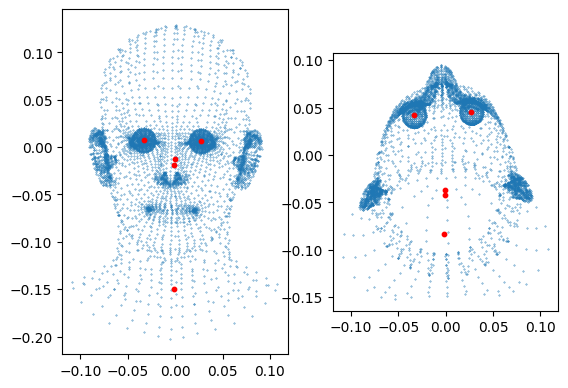

In [5]:
vertices, J_transformed = deca.flame(codedict['shape'], codedict['exp'], codedict['pose'], get_J=True)
v_cpu = vertices.detach().cpu().numpy()[0]
J_transformed = J_transformed.detach().cpu().numpy()[0]
fig, axs = plt.subplots(1, 2)

def show(ax, ax0=0, ax1=1):
    ax.scatter(v_cpu[:, ax0], v_cpu[:, ax1], s=0.1)
    ax.scatter(J_transformed[:, ax0], J_transformed[:, ax1], s=10, c='r')
    ax.set_aspect(1.)
    
show(axs[0], 0, 1)
show(axs[1], 0, 2)

plt.show()

# Skinning weights W

In [6]:
print(deca.flame.lbs_weights.shape)
print(deca.flame.lbs_weights.sum(axis=1))

torch.Size([5023, 5])
tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')


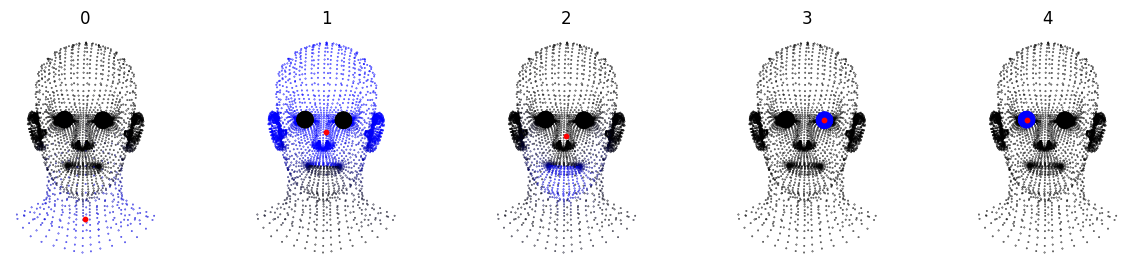

In [7]:
joints_num = deca.flame.lbs_weights.shape[1]
fig, axs = plt.subplots(1, joints_num, figsize=(15, 3))

def show(i, ax0=0, ax1=1):
    alpha = deca.flame.lbs_weights[:, i].detach().cpu().numpy().reshape(-1, 1)
    rgb = np.array([[0, 0, 1]], dtype=np.float32)
    black = np.array([[0, 0, 0]], dtype=np.float32)
    cols = alpha * rgb + (1 - alpha) * black
    
    axs[i].scatter(v_cpu[:, ax0], v_cpu[:, ax1], s=0.1, c=cols)
    axs[i].scatter(J_transformed[[i], ax0], J_transformed[[i], ax1], s=10, c='r')
    axs[i].set_aspect(1.)
    axs[i].set_title(i)
    axs[i].axis('off')
    
for joint_i in range(joints_num):
    show(joint_i, 0, 1)
    # show(axs[joint_i], 0, 2)

plt.show()

- Хоть 0ой джоинт и отвечает за глобальный поворот головы, но в его скиннинг распространяется только на шею
- 1ый отвечает за, например, кивок головы
- 2ой джоинт - за движение челюсти
- 3ий и 4ый - за глаза

# Create simple animation

`codedict['pose'].shape == (1, 6)` - тут 0ой и 2ой (sec., да, бред) джоинт

`deca.flame.neck_pose.shape == (1, 3)` - тут 1ой

`deca.flame.eye_pose.shape == (1, 6)` - тут 3 и 4ый (глаза)

Все в формате aa (axis-angle)

In [8]:
codedict['pose']

tensor([[ 0.1242, -0.0375, -0.0062,  0.0603,  0.0190, -0.0347]],
       device='cuda:0')

In [9]:
tta = dict(dtype=codedict['pose'].dtype, device=codedict['pose'].device)    

In [10]:
def render_animation(animation, save_name=None, custom_render_f=None, verbose=False):
    if save_name is not None:
        out = None

    iterator = range(animation['n_frames'])
    if verbose:
        iterator = tqdm_notebook(iterator)
    for i in iterator:
        j0 = animation['animation_aa']['j0'][i]
        j1 = animation['animation_aa']['j1'][i]
        j2 = animation['animation_aa']['j2'][i]

        pose = torch.tensor(np.concatenate((j0, j2)).reshape(1, -1), **tta)
        j1 = torch.tensor(j1.reshape(1, -1), **tta)
        deca.flame.neck_pose[:] = j1[:]
        perturbate_skinning = False
        if 'perturbate_skinning' in animation['animation_aa']:
            perturbate_skinning = animation['animation_aa']['perturbate_skinning'][i]
        if perturbate_skinning:
            deca.flame.lbs_weights = w_new
        vertices, J_transformed = deca.flame(codedict['shape'], codedict['exp'], pose, get_J=True)
        if perturbate_skinning:
            deca.flame.lbs_weights = w_dump.clone() # restore skinning
        deca.flame.neck_pose[:] = 0
        v_cpu = vertices.detach().cpu().numpy()[0]
        J_transformed = J_transformed.detach().cpu().numpy()[0]
        
        if custom_render_f is None:
            fig, axs = plt.subplots()

            def show(ax, ax0=0, ax1=1):
                ax.scatter(v_cpu[:, ax0], v_cpu[:, ax1], s=0.1)
                ax.scatter(J_transformed[:, ax0], J_transformed[:, ax1], s=10, c='r')
                ax.set_aspect(1.)
                ax.set_xlim(-.2, .2)
                ax.set_ylim(-.2, .2)
                ax.axis('off')
            show(axs, 0, 1)
        
        if save_name is not None:
            if custom_render_f is not None:
                img = custom_render_f(vertices)[0,..., :3]
                img = (img * 255).round().clip(0, 255).astype(np.uint8)
            else:
                fig.tight_layout(pad=0)
                axs.margins(0)
                fig.canvas.draw()
                img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            
            h, w = img.shape[:2]
            if out is None:
                fps = animation['fps']
                output_fp = f'{task_data_dir}/results/{save_name}.mp4'
                print(f'saving video to {output_fp}')
                out = cv2.VideoWriter(
                    output_fp,
                    cv2.VideoWriter_fourcc('M','J','P','G'), 
                    fps, 
                    (w, h)
                )
            out.write(img[..., [2, 1, 0]])
            plt.close()
        else:
            plt.show()

    if save_name is not None:
        out.release()

In [11]:
def get_animation1(fps, duration_secs = 3):
    n_frames = fps * duration_secs

    animation_aa = dict(j0=[], j1=[], j2=[])
    for i in range(n_frames):
        
        
        ################
        ##### TODO #####
        ################
        j0 = np.array([0, 0, np.sin(i / n_frames * 2 * np.pi) * 0.3])
        j1 = np.array([...])
        j2 = codedict['pose'][0, 3:].detach().cpu().numpy() # use jaw pose from mesh fit
        ################
        ##### TODO #####
        ################
        

        animation_aa['j0'].append(j0)
        animation_aa['j1'].append(j1)
        animation_aa['j2'].append(j2)

    for k in animation_aa.keys():
        animation_aa[k] = np.array(animation_aa[k])
    
    result = dict(
        fps=fps, 
        duration_secs=duration_secs, 
        n_frames=n_frames,
        animation_aa=animation_aa
    )
    return result

j0 (9, 3)
j1 (9, 3)
j2 (9, 3)


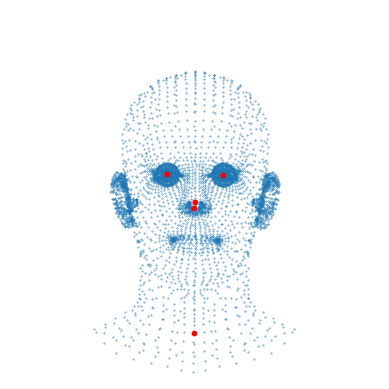

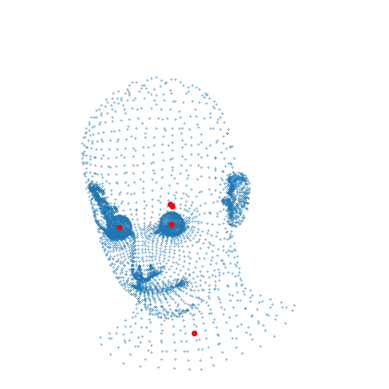

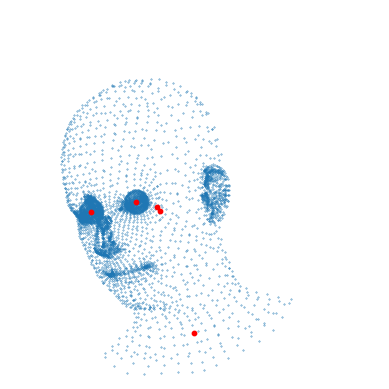

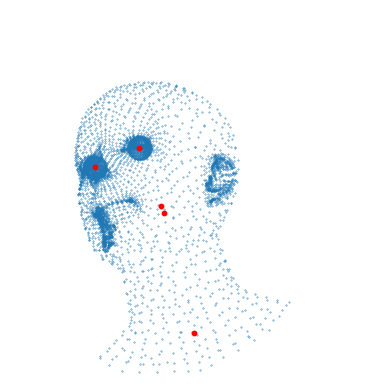

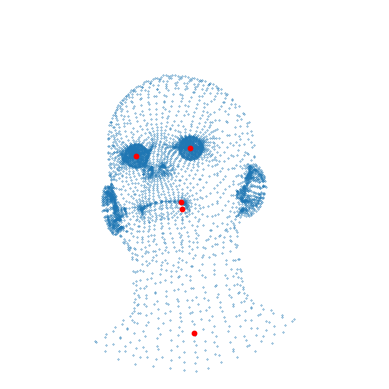

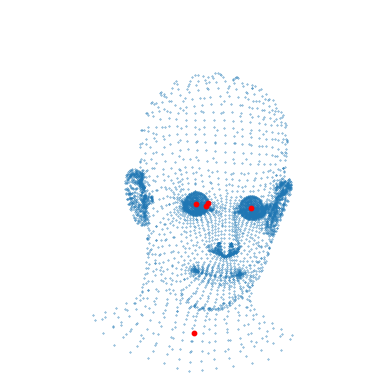

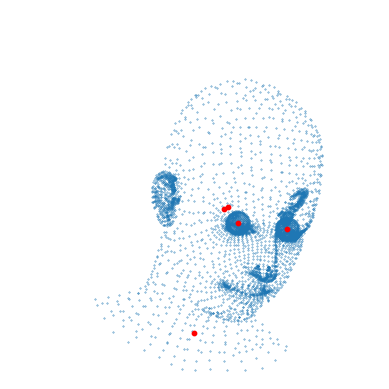

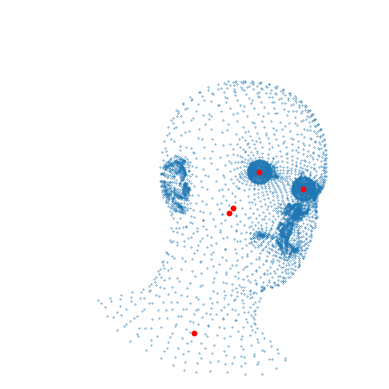

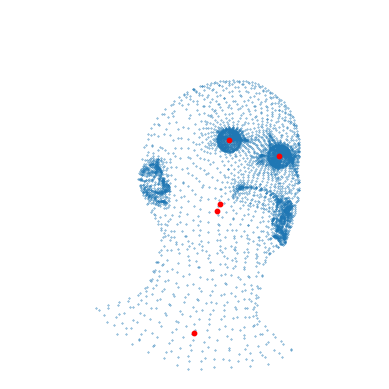

In [12]:
# debug w/ low fps and w/o saving video to see the results here
animation1 = get_animation1(fps=3)

for k, v in animation1['animation_aa'].items():
    print(k, v.shape)

render_animation(animation1, save_name=None)  

In [13]:
# then debug with saving video
animation1 = get_animation1(fps=30)
render_animation(animation=animation1, save_name='01_animation') 

saving video to task_data/results/01_animation.mp4


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Ваша анимация с более высоким fps сохранена в видео, путь выше.

# Perturbate skinning

In [18]:
# uncomment and do once, then comment back
# w_dump = deca.flame.lbs_weights.clone()

Придумайте, как изменить веса скиннинга, чтобы меш прикольно/странно выглядел

In [19]:
w_new = w_dump.clone()


################
##### TODO #####
################
w_new = ...
################
##### TODO #####
################



deca.flame.lbs_weights = w_new
render_animation(animation1, save_name='02_perturbate_w')
deca.flame.lbs_weights = w_dump.clone() # restore original skinning

saving video to task_data/results/02_perturbate_w.mp4


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Результат в видео, путь выше.

# Visualize with texture

В этом разделе нет TODO, просто посмотрите результат в новом видео.

In [20]:
verts, J_transformed = deca.flame(codedict['shape'], codedict['exp'], codedict['pose'], get_J=True)

faces = deca.render.faces[0].cpu().numpy()
texture = util.tensor2image(opdict['uv_texture_gt'][0])[..., [2, 1, 0]]
uvcoords = deca.render.raw_uvcoords[0].cpu().numpy()
uvfaces = deca.render.uvfaces[0].cpu().numpy()

for el in [faces, texture, uvcoords, uvfaces]:
    print(el.shape, el.dtype)

(9976, 3) int64
(256, 256, 3) uint8
(5118, 2) float32
(9976, 3) int64


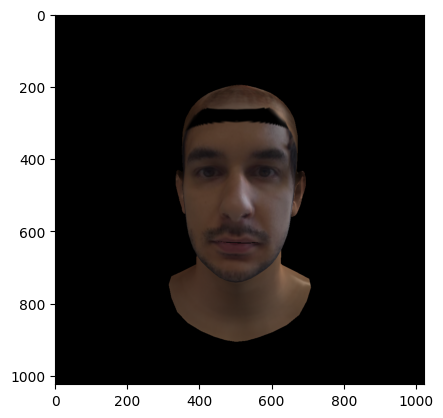

In [21]:
import pytorch3d
from pytorch3d.structures import Meshes
# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex, SoftPhongShader
)

def make_mesh(verts_3d, faces_3d, texture, faces_2d, verts_2d):
    textures = pytorch3d.renderer.mesh.textures.TexturesUV(texture, faces_2d, verts_2d)
    mesh = Meshes(
        verts=verts_3d,   
        faces=faces_3d, 
        textures=textures
    )
    return mesh

def render_mesh(mesh, distance=3, elevation=30, azimuth=0):    
    cameras = FoVPerspectiveCameras(znear=.1, zfar=10, device=device)    

    raster_settings = RasterizationSettings(
        image_size=1024, 
        blur_radius=0.0, 
        faces_per_pixel=1,
        cull_backfaces=True
    )
    # We can add a point light in front of the object. 
    lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))
    phong_renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(device=device, cameras=cameras, blend_params=blend_params, lights=lights)
    )
    
    R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

    image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)
    return image_ref


distance = .4 # дистанция от камеры по объекта
elevation = 0 # в градусах
azimuth = 0 # в градусах


def make_tensor(t, long=False):
    result = torch.tensor(t[None, ...], dtype=torch.long if long else torch.float, device=device).contiguous()
    return result


def pyt3d_render(verts):
    verts_new = verts.clone()
    verts_new[..., 1] += .02
    mesh = make_mesh(
        verts_new, 
        make_tensor(faces, long=True), 
        make_tensor(texture) / 255, 
        make_tensor(uvfaces, long=True), 
        make_tensor(uvcoords)
    )
    image_ref = render_mesh(mesh, distance=distance, elevation=elevation, azimuth=azimuth)
    image_ref_np = image_ref.cpu().numpy()
    return image_ref_np


img = pyt3d_render(verts)[0, ..., :3]
plt.imshow(img)
plt.show()

In [22]:
deca.flame.lbs_weights = w_new
render_animation(animation1, '03_texture', custom_render_f=pyt3d_render)
deca.flame.lbs_weights = w_dump.clone() # restore skinning

saving video to task_data/results/03_texture.mp4


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Результат в видео, путь выше.

# Create animation for music

Самая объемная часть задания

Нужно придумать анимацию под музыку

In [29]:
# Включите трек task_data/physically_fit.mp4

# В треках есть биты (beats), 4 бита - 1 такт (bar)
# "one two three four" is one bar, exactly like you are saying "boom boom boom boom" is one bar
bpm = 130  # beats per minute for the song
fps = 60
bs = 36  # num of bars, controls duration
# bs = 20

In [30]:
# Какая-то расшифровка тактов (bars):

# 1,2   : ту-ту-ту-туру|-ту-ту-туру-туру == 
# 3,4   : ту-ту-ту-туру|-ту-ту-туру-туру == 
# 5,6   : ту-ту-ту-туру|-ту-ту-туру-туру ==  All girls around the world, [что-то на Мадагаскарском]
# 7,8   : ту-ту-ту-туру|-ту-ту-туру-туру ==  [что-то на Мадагаскарском]
# 9,10  : ту-ту-ту-туру|-ту-ту-туру-туру ==  ... move them body ...
# 11,12 : ту-ту-ту-туру|-ту-ту-туру-туру ==  ... sexy

# 13,14 : ... == Woman ya cute ....
# 15,16 : ... == Woman ya cute ....

# 17,18 : ... == Physically fit, physically fit. Physically, physically, physically fit
# 19,20 : ... == Physically fit, physically fit. Physically, physically, physically fit

# 21,22 : ... == Woman, ya nice, ... physically ...
# 23,24 : ... == Woman, ya nice, sweet, fantastic! ...
# 25,26 : ... == Woman, ya nice, ... physically ...
# 27,28 : ... == Woman, ya nice, ... physically ...

# 29,30 : ... == I like to move it, move it. You like to move it, move it.
# 31,32 : ... == We like to move it, move it. ... move it!
# 33,34 : ... == I like to move it, move it. You like to move it, move it.
# 35,36 : ... == We like to move it, move it. ... move it!

In [32]:
def get_animation2(bpm, fps, bs):
    b_len_sec = 4 / bpm * 60  # duration of 1 bar = 4 beats
    duration_secs = bs * b_len_sec
    print(f'Duration = {duration_secs:.2f} secs = {bs} bars')
    n_frames = round(duration_secs * fps)
    p = one_beat_frames = fps * 60 / bpm
    print(f'1 beat = {p:.2f} frames = {b_len_sec / 4:.2} secs')
    freq = 2 * np.pi / p
    phase = np.pi / 4
    
    animation_aa = dict(j0=[], j1=[], j2=[], perturbate_skinning=[])
    
    for i in range(n_frames):
        cur_b = i / (4 * p)  # current bar number
        
        
        ################
        ##### TODO #####
        ################
        j0 = np.array([np.sin(i * freq + phase) * .2, 0, 0])
        j1 = np.array([0, np.sin(i * freq + phase) * .2, 0])
        j2 = codedict['pose'][0, 3:].detach().cpu().numpy()  # use jaw pose from mesh fit
        perturbate_skinning = False
        ################
        ##### TODO #####
        ################
        

        animation_aa['j0'].append(j0)
        animation_aa['j1'].append(j1)
        animation_aa['j2'].append(j2)
        animation_aa['perturbate_skinning'].append(perturbate_skinning)

    for k in animation_aa.keys():
        animation_aa[k] = np.array(animation_aa[k], dtype=np.float32)
    
    result = dict(
        fps=fps, 
        duration_secs=duration_secs, 
        n_frames=n_frames,
        animation_aa=animation_aa,
        p=p
    )
    return result

animation2 = get_animation2(bpm, fps, bs)

Duration = 66.46 secs = 36 bars
1 beat = 27.69 frames = 0.46 secs


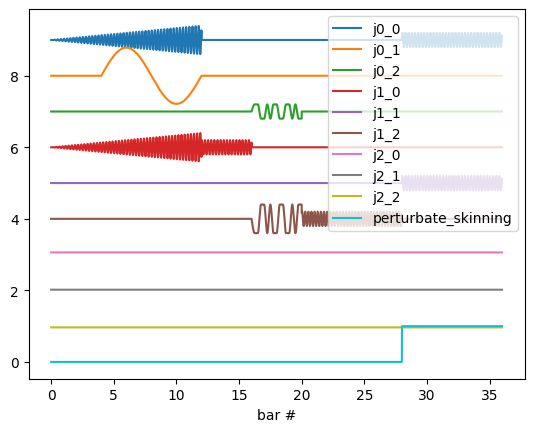

In [33]:
ys = defaultdict(list)
# xs = np.arange(animation2['n_frames']) / animation2['fps']
xs = np.arange(animation2['n_frames']) / (4 * animation2['p'])
# sl = np.where((xs > 16) & (xs < 20))[0]
sl = slice(None, None)
for frame_i in range(animation2['n_frames']):
    for joint in ['j0', 'j1', 'j2']:
        for axis in range(3):
            name = f'{joint}_{axis}'
            angle = animation2['animation_aa'][joint][frame_i][axis]
            ys[name].append(angle)
            
vis_y = 9
for joint in ['j0', 'j1', 'j2']:
    for axis in range(3):
        name = f'{joint}_{axis}'
        angles = np.array(ys[name])
        plt.plot(xs[sl], (angles + vis_y)[sl], label=name)
        vis_y -= 1
        
if 'perturbate_skinning' in animation2['animation_aa']:
    angles = animation2['animation_aa']['perturbate_skinning']
    plt.plot(xs[sl], (angles + vis_y)[sl], label='perturbate_skinning')    
        
plt.xlabel('bar #')
plt.legend()
plt.show()

Выше визуализация того, как меняются углы для вашей анимации 3ех джоинтов (для каждого 3 угла) + когда включается пертурбация скиннинг весов.

Это мой промежуточный вариант (есть рваные движения), заморачиваться не обязательно.

OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/3988 [00:00<?, ?it/s]

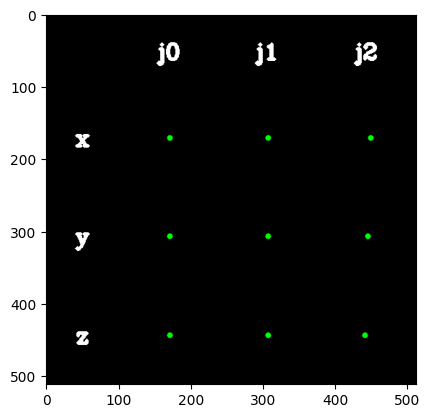

In [34]:
w = h = 512
aa_vis_sample_fp = f'{task_data_dir}/aa_vis_sample.mp4'
out = cv2.VideoWriter(
    aa_vis_sample_fp,
    cv2.VideoWriter_fourcc('M','J','P','G'), 
    animation2['fps'], 
    (w, h)
)

def add_text(frame, text, xy):
    # print(frame.shape, text, xy)
    x, y = xy
    font = cv2.FONT_HERSHEY_COMPLEX
    size = 1
    thickness = 3
    textsize = cv2.getTextSize(text, font, size, thickness)[0]
    # print(text, textsize)
    frame = cv2.putText(frame, text, (x - textsize[0] // 2, y + textsize[1] // 2), font, size, (255,255,255), thickness)
    return frame

x_coords = np.array([1/6, 1/6 + 1/3, 1/6 + 2/3]) * .8 + .2
y_coords = x_coords.copy()

# for i in tqdm_notebook(range(n_frames)):
for i in tqdm_notebook(range(animation2['n_frames'])):
    frame = np.zeros((h, w, 3), dtype=np.uint8)
    for _ in range(3):
        frame = add_text(frame, 'j' + str(_), (round(x_coords[_] * w), round(.1 * h)))
        frame = add_text(frame, {0:'x', 1:'y', 2:'z'}[_], (round(.1 * w), round(x_coords[_] * w)))
    for x_index, joint in enumerate(['j0', 'j1', 'j2']):
        for y_index in range(3):
            angle = animation2['animation_aa'][joint][i][y_index]
            x = x_coords[x_index] + angle * 1/6
            y = y_coords[y_index]
            x = round(x * w)
            y = round(y * w)
            frame = cv2.circle(frame, (x, y), radius=1, color=[0, 255, 0], thickness=5)
    if i == 0:
        plt.imshow(frame)
        plt.show()
    out.write(frame[..., [2, 1, 0]])
out.release()

In [35]:
def add_music(name):
    video = mpe.VideoFileClip(f'{task_data_dir}/{name}.mp4')
    audio = mpe.VideoFileClip(f'{task_data_dir}/physically_fit.mp4')
    audio = audio.subclip(0, video.duration)
    result_audio = mpe.CompositeAudioClip([audio.audio])
    result = video.set_audio(result_audio)
    aa_vis_sample_music_fp = f'{task_data_dir}/{name}_music.mp4'
    result.write_videofile(aa_vis_sample_music_fp)

add_music('aa_vis_sample')

Moviepy - Building video task_data/aa_vis_sample_music.mp4.
MoviePy - Writing audio in aa_vis_sample_musicTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video task_data/aa_vis_sample_music.mp4



Moviepy - Done !
Moviepy - video ready task_data/aa_vis_sample_music.mp4


Еще визуализация анимации, только уже под музыку.

In [37]:
render_animation(animation2, '04_music', custom_render_f=pyt3d_render, verbose=True)
add_music('results/04_music')

  0%|          | 0/3988 [00:00<?, ?it/s]

saving video to task_data/results/04_music.mp4


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Moviepy - Building video task_data/results/04_music_music.mp4.
MoviePy - Writing audio in 04_music_musicTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video task_data/results/04_music_music.mp4



Moviepy - Done !
Moviepy - video ready task_data/results/04_music_music.mp4


Финальный результат, ура!

Поместите вашу качающую под музыку голову `task_data/results/04_music_music.mp4` в архив и отправьте мне в тг @rmbashirov. Сделаю общий коллаж.

Разрешение должно быть 1024x1024, длина видео ~1m:06s, 60fps.